# Focus Stacking - Profondeur de Champ Étendue

Ce notebook combine plusieurs images acquises à différentes profondeurs (Z) pour créer une image finale avec une profondeur de champ étendue.

**Structure des données:**
- `../data/images/Poudre/X50/` - Images de poudre étalée
- `../data/images/Poudre compactée/` - Images de poudre compactée

**Résultats:**
- `../results/focus_stacking/Poudre/X50/` - Images finales poudre
- `../results/focus_stacking/Poudre_compactée/` - Images finales poudre compactée

## 1. Import des bibliothèques

In [3]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image

print("✓ Bibliothèques importées avec succès")

✓ Bibliothèques importées avec succès


## 2. Paramètres généraux

In [4]:
# ==============================
# PARAMÈTRES GÉNÉRAUX
# ==============================

INPUT_ROOT = Path("../data/images")        # Dossier racine contenant Poudre / Poudre compactée
OUTPUT_ROOT = Path("../results/focus_stacking")  # Dossier de sortie
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp", ".BMP")

print(f"📁 Dossier d'entrée: {INPUT_ROOT}")
print(f"📁 Dossier de sortie: {OUTPUT_ROOT}")
print(f"✓ Dossier de sortie créé")

📁 Dossier d'entrée: ..\data\images
📁 Dossier de sortie: ..\results\focus_stacking
✓ Dossier de sortie créé


## 3. Fonction Focus Stacking

In [5]:
# ==============================
# FONCTION FOCUS STACKING
# ==============================

def focus_stack(images):
    """
    Combine une liste d'images (numpy arrays) acquises à différents Z
    en une image à profondeur de champ étendue.
    
    Paramètres:
    -----------
    images : list of numpy.ndarray
        Liste d'images BGR de même taille
        
    Retourne:
    ---------
    numpy.ndarray
        Image combinée avec profondeur de champ étendue
    """
    # Calcul du Laplacien pour chaque image (mesure de netteté)
    laplacians = [cv2.Laplacian(img, cv2.CV_64F).var(axis=2) for img in images]
    laplacians = np.stack(laplacians, axis=0)

    # Trouver l'indice de l'image la plus nette pour chaque pixel
    best_focus_idx = np.argmax(laplacians, axis=0)

    # Créer l'image finale en prenant le meilleur pixel de chaque image
    stacked = np.zeros_like(images[0])
    for i in range(len(images)):
        mask = best_focus_idx == i
        stacked[mask] = images[i][mask]

    return stacked


def load_images_from_folder(folder, debug=False):
    """
    Charge toutes les images d'un dossier.
    Utilise PIL pour les BMP (plus robuste) et cv2 comme fallback.
    
    Paramètres:
    -----------
    folder : Path
        Chemin du dossier contenant les images
    debug : bool
        Affiche les informations de debug
        
    Retourne:
    ---------
    tuple (list, list)
        Liste des images et liste des fichiers
    """
    images = []
    image_files = []
    
    if not folder.exists():
        if debug:
            print(f"      ⚠️  Dossier n'existe pas: {folder}")
        return images, image_files
    
    # Parcourir tous les fichiers du dossier
    all_files = list(folder.iterdir())
    
    if debug:
        print(f"      📂 Fichiers trouvés: {len(all_files)}")
        for f in sorted(all_files)[:3]:
            print(f"         - {f.name} (suffix: {f.suffix})")
    
    # Filtrer par extension (case-insensitive)
    for f in sorted(all_files):
        if f.is_file() and f.suffix.lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}:
            img = None
            
            # Pour les BMP, essayer PIL d'abord
            if f.suffix.lower() == ".bmp":
                try:
                    pil_img = Image.open(str(f))
                    # Convertir en RGB si nécessaire
                    if pil_img.mode != 'RGB':
                        pil_img = pil_img.convert('RGB')
                    # Convertir en numpy array et BGR pour OpenCV
                    img_rgb = np.array(pil_img)
                    img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
                    if debug:
                        print(f"      ✓ Image chargée (PIL): {f.name}")
                except Exception as e:
                    if debug:
                        print(f"      ❌ Erreur PIL: {f.name} ({str(e)[:30]})")
            else:
                # Pour les autres formats, utiliser cv2
                img = cv2.imread(str(f))
                if img is not None and debug:
                    print(f"      ✓ Image chargée (cv2): {f.name}")
            
            # Ajouter l'image si chargée avec succès
            if img is not None:
                images.append(img)
                image_files.append(f)
            elif debug and f.suffix.lower() != ".bmp":
                print(f"      ❌ Erreur cv2.imread: {f.name}")

    return images, image_files

print("✓ Fonctions de focus stacking définies")

✓ Fonctions de focus stacking définies


## 4. Traitement : Poudre étalée

In [6]:
# ==============================
# TRAITEMENT : POUDRE ÉTALÉE
# ==============================

def process_poudre():
    """
    Traite les images de poudre étalée (X50).
    Structure: Data/Poudre/X50/[zone]/images...
    """
    # S'assurer que les paramètres globaux sont définis
    global INPUT_ROOT, OUTPUT_ROOT
    if "INPUT_ROOT" not in globals():
        INPUT_ROOT = Path("../data/images")
    if "OUTPUT_ROOT" not in globals():
        OUTPUT_ROOT = Path("../results/focus_stacking")
        OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

    poudre_x50 = INPUT_ROOT / "Poudre" / "X50"
    output_dir = OUTPUT_ROOT
    output_dir.mkdir(parents=True, exist_ok=True)

    if not poudre_x50.exists():
        print(f"⚠️  Dossier {poudre_x50} non trouvé")
        return

    success_count = 0
    
    for zone in poudre_x50.iterdir():
        if not zone.is_dir():
            continue

        images, files = load_images_from_folder(zone)
        if len(images) < 2:
            print(f"⚠️  {zone.name}: pas assez d'images ({len(images)})")
            continue

        print(f"🔬 Traitement {zone.name} ({len(images)} images)...")
        
        try:
            stacked = focus_stack(images)
            
            # Nom descriptif: Zone_NumImages_Dimensions
            h, w = stacked.shape[:2]
            filename = f"Poudre_Etalee_{zone.name}_{len(images)}img_{w}x{h}px.jpg"
            output_path = output_dir / filename
            cv2.imwrite(str(output_path), stacked)
            print(f"   ✓ Sauvegardé: {output_path.name}")
            success_count += 1
            
        except Exception as e:
            print(f"   ❌ Erreur traitement: {str(e)}")

    print(f"✅ {success_count} image(s) de poudre étalée générée(s)")

# Exécuter le traitement
print("=== TRAITEMENT POUDRE ÉTALÉE ===")
process_poudre()
print()

=== TRAITEMENT POUDRE ÉTALÉE ===
🔬 Traitement ZONE 5 (9 images)...
   ✓ Sauvegardé: Poudre_Etalee_ZONE 5_9img_928x624px.jpg
🔬 Traitement ZONE1 (4 images)...
   ✓ Sauvegardé: Poudre_Etalee_ZONE1_4img_928x624px.jpg
🔬 Traitement ZONE2 (6 images)...
   ✓ Sauvegardé: Poudre_Etalee_ZONE2_6img_928x624px.jpg
🔬 Traitement ZONE3 (3 images)...
   ✓ Sauvegardé: Poudre_Etalee_ZONE3_3img_928x624px.jpg
🔬 Traitement ZONE4 (3 images)...
   ✓ Sauvegardé: Poudre_Etalee_ZONE4_3img_928x624px.jpg
✅ 5 image(s) de poudre étalée générée(s)



## 5. Traitement : Poudre compactée

In [7]:
# ==============================
# TRAITEMENT : POUDRE COMPACTÉE
# ==============================

def process_poudre_compactee(debug=False):
    """
    Traite les images de poudre compactée.
    Structure: ../data/images/Poudre compactée/[test]/X50/images...
    """
    # S'assurer que les paramètres globaux sont définis
    global INPUT_ROOT, OUTPUT_ROOT
    if "INPUT_ROOT" not in globals():
        INPUT_ROOT = Path("../data/images")
    if "OUTPUT_ROOT" not in globals():
        OUTPUT_ROOT = Path("../results/focus_stacking")
        OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

    poudre_compactee = INPUT_ROOT / "Poudre compactée"
    output_dir = OUTPUT_ROOT
    output_dir.mkdir(parents=True, exist_ok=True)

    if not poudre_compactee.exists():
        print(f"⚠️  Dossier {poudre_compactee} non trouvé")
        return

    if debug:
        print(f"📁 Dossier de sortie: {output_dir.absolute()}")
        print(f"   Existe: {output_dir.exists()}")

    success_count = 0
    
    for test in sorted(poudre_compactee.iterdir()):
        if not test.is_dir():
            continue

        x50_folder = test / "X50"
        if not x50_folder.exists():
            print(f"⚠️  {test.name}: dossier X50 non trouvé")
            continue

        if debug:
            print(f"\n🔍 Debug: {test.name}")
            print(f"   Chemin absolu: {x50_folder.absolute()}")
            print(f"   Existe: {x50_folder.exists()}")
        
        images, files = load_images_from_folder(x50_folder, debug=debug)
        
        if len(images) == 0:
            print(f"⚠️  {test.name}: aucune image trouvée dans {x50_folder}")
            if debug:
                all_files = list(x50_folder.iterdir())
                print(f"      Fichiers dans le dossier: {[f.name for f in all_files[:5]]}")
            continue
        
        if len(images) < 2:
            print(f"⚠️  {test.name}: pas assez d'images ({len(images)})")
            continue

        print(f"🧪 Traitement {test.name} X50 ({len(images)} images)...")
        
        try:
            stacked = focus_stack(images)
            print(f"   ✓ Focus stacking complété - Image shape: {stacked.shape}, dtype: {stacked.dtype}")
            
            # Nom descriptif: Test_X50_NumImages_Dimensions
            h, w = stacked.shape[:2]
            filename = f"Poudre_Compactee_{test.name.replace(' ', '_')}_X50_{len(images)}img_{w}x{h}px.jpg"
            output_path = output_dir / filename
            
            if debug:
                print(f"   Chemin sortie: {output_path.absolute()}")
                print(f"   Dossier existe: {output_path.parent.exists()}")
            
            # S'assurer que le dossier existe
            output_path.parent.mkdir(parents=True, exist_ok=True)
            
            # Convertir en uint8 si nécessaire (cv2.imwrite aime uint8)
            if stacked.dtype != np.uint8:
                print(f"   ℹ️  Conversion dtype {stacked.dtype} -> uint8")
                stacked = cv2.convertScaleAbs(stacked)
            
            success = cv2.imwrite(str(output_path), stacked)
            
            if success:
                print(f"   ✓ Sauvegardé: {output_path.name}")
                success_count += 1
            else:
                print(f"   ❌ Erreur cv2.imwrite: retourna False")
                # Fallback avec PIL
                print(f"   Tentative PIL...")
                try:
                    stacked_rgb = cv2.cvtColor(stacked, cv2.COLOR_BGR2RGB)
                    pil_img = Image.fromarray(stacked_rgb)
                    output_path_pil = output_path.with_suffix('.jpg')
                    pil_img.save(str(output_path_pil))
                    print(f"   ✓ Sauvegardé (PIL JPG): {output_path_pil.name}")
                    success_count += 1
                except Exception as e2:
                    print(f"   ❌ Erreur PIL: {str(e2)}")
            
        except Exception as e:
            print(f"   ❌ Erreur traitement: {str(e)}")
            import traceback
            traceback.print_exc()

    print(f"\n✅ {success_count} image(s) de poudre compactée générée(s)")

# Exécuter le traitement avec debug
print("=== TRAITEMENT POUDRE COMPACTÉE ===")
process_poudre_compactee(debug=True)
print()

=== TRAITEMENT POUDRE COMPACTÉE ===
📁 Dossier de sortie: c:\Users\marwa\OneDrive\Desktop\Analyse_Raman\Image_RAMA\raman_project\notebooks\..\results\focus_stacking
   Existe: True

🔍 Debug: Test 1
   Chemin absolu: c:\Users\marwa\OneDrive\Desktop\Analyse_Raman\Image_RAMA\raman_project\notebooks\..\data\images\Poudre compactée\Test 1\X50
   Existe: True
      📂 Fichiers trouvés: 20
         - BA-08-00-X50-1-10.bmp (suffix: .bmp)
         - BA-08-00-X50-1-11.bmp (suffix: .bmp)
         - BA-08-00-X50-1-12.bmp (suffix: .bmp)
      ✓ Image chargée (PIL): BA-08-00-X50-1-10.bmp
      ✓ Image chargée (PIL): BA-08-00-X50-1-11.bmp
      ✓ Image chargée (PIL): BA-08-00-X50-1-12.bmp
      ✓ Image chargée (PIL): BA-08-00-X50-1-13.bmp
      ✓ Image chargée (PIL): BA-08-00-X50-1-14.bmp
      ✓ Image chargée (PIL): BA-08-00-X50-1-15.bmp
      ✓ Image chargée (PIL): BA-08-00-X50-1-16.bmp
      ✓ Image chargée (PIL): BA-08-00-X50-1-17.bmp
      ✓ Image chargée (PIL): BA-08-00-X50-1-18.bmp
      ✓ Image

## 6. Résumé des résultats

In [8]:
# Afficher un résumé des fichiers générés
print("=" * 80)
print("📊 RÉSUMÉ DES RÉSULTATS")
print("=" * 80)

# Tous les fichiers dans le dossier de sortie
if OUTPUT_ROOT.exists():
    all_files = sorted(list(OUTPUT_ROOT.glob("*.tif")) + list(OUTPUT_ROOT.glob("*.png")) + list(OUTPUT_ROOT.glob("*.jpg")))
    
    # Séparer par type
    poudre_files = [f for f in all_files if "Poudre_Etalee" in f.name]
    compactee_files = [f for f in all_files if "Poudre_Compactee" in f.name]
    
    print(f"\n📁 Poudre étalée: {len(poudre_files)} images générées")
    for f in poudre_files:
        print(f"   - {f.name}")
    
    print(f"\n📁 Poudre compactée: {len(compactee_files)} images générées")
    for f in compactee_files:
        print(f"   - {f.name}")

print("\n" + "=" * 80)
print("✅ TRAITEMENT TERMINÉ")
print("=" * 80)

📊 RÉSUMÉ DES RÉSULTATS

📁 Poudre étalée: 5 images générées
   - Poudre_Etalee_ZONE 5_9img_928x624px.jpg
   - Poudre_Etalee_ZONE1_4img_928x624px.jpg
   - Poudre_Etalee_ZONE2_6img_928x624px.jpg
   - Poudre_Etalee_ZONE3_3img_928x624px.jpg
   - Poudre_Etalee_ZONE4_3img_928x624px.jpg

📁 Poudre compactée: 2 images générées
   - Poudre_Compactee_Test_1_X50_20img_928x624px.jpg
   - Poudre_Compactee_Test_2_X50_20img_928x624px.jpg

✅ TRAITEMENT TERMINÉ


## 7. Affichage des images générées

Cette section affiche les images finales générées pour la poudre étalée et la poudre compactée.

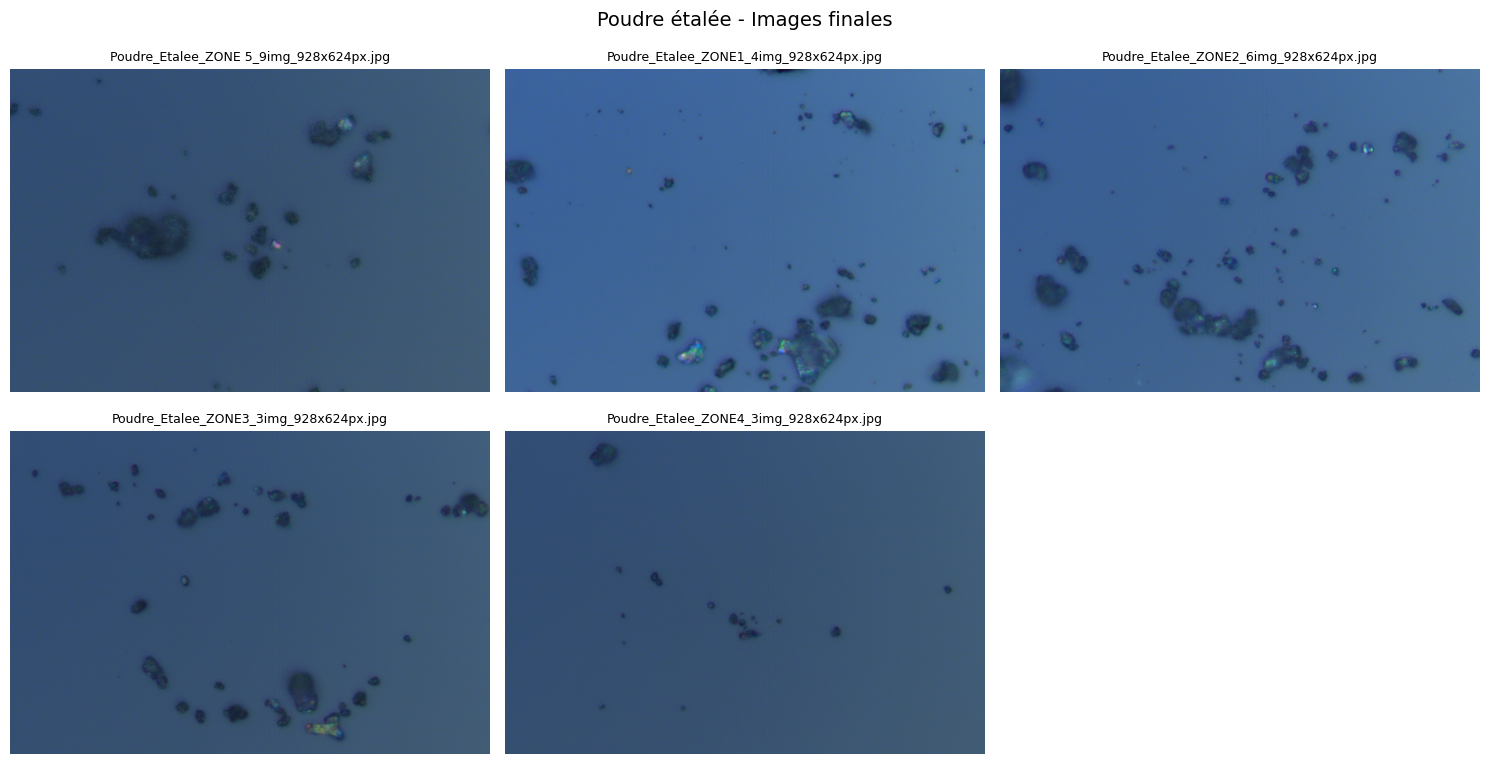

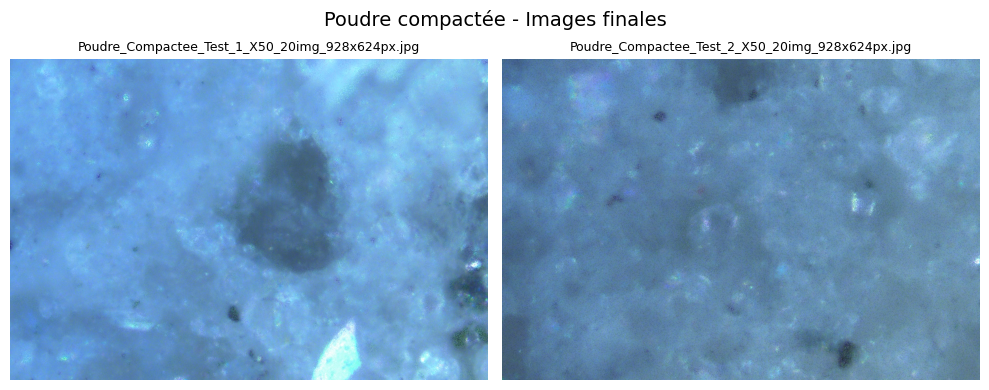

In [9]:
import matplotlib.pyplot as plt

# Récupérer toutes les images du dossier de sortie
all_images = sorted(list(OUTPUT_ROOT.glob("*.tif")) + list(OUTPUT_ROOT.glob("*.png")) + list(OUTPUT_ROOT.glob("*.jpg"))) if OUTPUT_ROOT.exists() else []

# Séparer par type
poudre_images = [f for f in all_images if "Poudre_Etalee" in f.name]
compactee_images = [f for f in all_images if "Poudre_Compactee" in f.name]

# Fonction d'affichage
def show_images(image_paths, title):
    if not image_paths:
        print(f"⚠️  Aucune image trouvée pour: {title}")
        return

    n = len(image_paths)
    cols = min(3, n)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(5 * cols, 4 * rows))
    plt.suptitle(title, fontsize=14)

    for i, img_path in enumerate(image_paths, 1):
        img = cv2.imread(str(img_path))
        if img is None:
            # Si cv2 échoue (ex: certains TIFF), utiliser PIL
            try:
                img = np.array(Image.open(str(img_path)))
            except Exception:
                print(f"❌ Impossible de lire: {img_path.name}")
                continue
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(img_path.name, fontsize=9)

    plt.tight_layout()
    plt.show()

# Afficher les images
show_images(poudre_images, "Poudre étalée - Images finales")
show_images(compactee_images, "Poudre compactée - Images finales")